# U-Net Based Retinal Vessel Segmentation
**A Project of IE4476 Image Processing, AY 2022/23 Sem 1, School of Electrical & Electronic Engineering, Nanyang Technological University**

Student: Tran Anh Quan, EEE/4

The work is based on the repository of Yao et al.: https://github.com/DeepTrial/Retina-VesselNet 



## Setting Up Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
#Change the current working directory to the path of Google Cloud Drive
path="/content/drive/My Drive/"
os.chdir(path)

In [ ]:
import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
gpus=tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


2.9.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!nvidia-smi
import os
import datetime
os.environ['CUDA_VISIBLE_DEVICES'] = "1"     #use GPU-0 
%load_ext tensorboard


Sun Nov 13 05:12:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install tqdm
!pip install matplotlib
!pip install opencv-python
!pip install tf-nightly
!pip install scikit-learn

!pip install onnxruntime
!pip install -U tf2onnx


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 542.6 MB 23 kB/s 
     |████████████████████████████████| 439 kB 77.4 MB/s 
     |████████████████████████████████| 6.0 MB 72.0 MB/s 
     |████████████████████████████████| 1.7 MB 59.9 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires fl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 14.7 MB/s 
     |████████████████████████████████| 46 kB 4.1 MB/s 
     |████████████████████████████████| 86 kB 6.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 442 kB 13.6 MB/s 
     |████████████████████████████████| 13.1 MB 71.4 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 22.10.26
    Uninstalling flatbuffers-22.10.26:
      Successfully uninstalled flatbuffers-22.10.26
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have

In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


In [ ]:
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Train-Validation Split
Images "24_training.tif", "26_training.tif", "32_training.tif", ""34_training.tif" are in the validation set. The other 16 images of DRIVE's training dataset is used for training.

In [ ]:
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import cv2
import os
import random
import time
import shutil
from sklearn.utils import shuffle
%matplotlib inline

patch_size=48       
patch_num=1000        
patch_threshold=25  
TRAIN_OR_VAL=0.8
dataset_path='/content/drive/MyDrive/DRIVE/'   

train_dir=dataset_path+"training/"
test_dir=dataset_path+"test/"

train_image_dir=train_dir+"images/"
train_mask_dir=train_dir+"mask/"
train_groundtruth_dir=train_dir+"1st_manual/"
train_patch_dir=train_dir+"patch/"

test_image_dir=test_dir+"images/"
test_mask_dir=test_dir+"mask/"
test_groundtruth_dir=test_dir+"groundtruth/"
test_save_dir=test_dir+"pred_result/"

train_image_path_list=glob(train_image_dir+"*.tif")
test_image_path_list=glob(test_image_dir+"*.tif")

print(train_image_path_list)
val_image_path_list=[
    '/content/drive/MyDrive/DRIVE/training/images/32_training.tif', 
    '/content/drive/MyDrive/DRIVE/training/images/34_training.tif', 
    '/content/drive/MyDrive/DRIVE/training/images/24_training.tif', 
    '/content/drive/MyDrive/DRIVE/training/images/26_training.tif', 
]
train_image_path_list=[i for i in train_image_path_list if i not in val_image_path_list]

print(train_image_path_list)

print("number of training images:",len(train_image_path_list))
print("number of validation images:",len(val_image_path_list))
print("number of testing images:",len(test_image_path_list))

['/content/drive/MyDrive/DRIVE/training/images/27_training.tif', '/content/drive/MyDrive/DRIVE/training/images/22_training.tif', '/content/drive/MyDrive/DRIVE/training/images/21_training.tif', '/content/drive/MyDrive/DRIVE/training/images/34_training.tif', '/content/drive/MyDrive/DRIVE/training/images/30_training.tif', '/content/drive/MyDrive/DRIVE/training/images/23_training.tif', '/content/drive/MyDrive/DRIVE/training/images/33_training.tif', '/content/drive/MyDrive/DRIVE/training/images/25_training.tif', '/content/drive/MyDrive/DRIVE/training/images/37_training.tif', '/content/drive/MyDrive/DRIVE/training/images/28_training.tif', '/content/drive/MyDrive/DRIVE/training/images/31_training.tif', '/content/drive/MyDrive/DRIVE/training/images/29_training.tif', '/content/drive/MyDrive/DRIVE/training/images/32_training.tif', '/content/drive/MyDrive/DRIVE/training/images/35_training.tif', '/content/drive/MyDrive/DRIVE/training/images/24_training.tif', '/content/drive/MyDrive/DRIVE/training/

## Data Preprocessing

In [ ]:
# normalize the images
def restrict_normalized(imgs,mask):
    imgs_normalized = np.empty(imgs.shape)
    imgs_std = np.std(imgs)
    imgs_mean = np.mean(imgs)
    imgs_normalized = (imgs-imgs_mean)/imgs_std
    for i in range(imgs.shape[2]):
        imgs_normalized[:,:,i] = ((imgs_normalized[:,:,i] - np.min(imgs_normalized[:,:,i])) / (np.max(imgs_normalized[:,:,i])-np.min(imgs_normalized[:,:,i])))*255
    return imgs_normalized

# CLAHE (Contrast Limited Adaptive Histogram Equalization)
def clahe_equalized(imgs):
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  imgs_equalized = np.empty(imgs.shape)
  for i in range(imgs.shape[2]):
    imgs_equalized[:,:,i] = clahe.apply(np.array(imgs[:,:,i], dtype = np.uint8))
  return imgs_equalized

def normalized(imgs):
  imgs_normalized =np.empty(imgs.shape)
  for i in range(imgs.shape[2]):
    imgs_normalized[:,:,i] =cv2.equalizeHist(imgs[:,:,i])
  return imgs_normalized

# inverse gamma correction
def adjust_gamma(imgs, gamma=1.0):
  invGamma = 1.0 / gamma
  table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
  # apply gamma correction using the lookup table
  new_imgs = np.empty(imgs.shape)
  for i in range(imgs.shape[2]):
    new_imgs[:,:,i] = cv2.LUT(np.array(imgs[:,:,i], dtype = np.uint8), table)
  return new_imgs

def preprocess(image,mask):
  assert np.max(mask)==1
  image=np.array(image)
  image[:,:,0]=image[:,:,0]*mask
  image[:,:,1]=image[:,:,1]*mask
  image[:,:,2]=image[:,:,2]*mask
  
  image=restrict_normalized(image,mask)
  image=clahe_equalized(image)
  image=adjust_gamma(image,1.2)
  image=image/255.0
  return image

## Creating patches from Training and Validation images
The generated patches and their ground truth are saved in the defined directory

In [ ]:
def check_coord(x,y,h,w,patch_size):
  if x-patch_size/2>0 and x+patch_size/2<h and y-patch_size/2>0 and y+patch_size/2<w:
    return True
  return False

def image2patch(image_path,patch_num,patch_size,training=True,show=True):
  image_name=image_path.split("/")[-1].split("_")[0]

  image=plt.imread(image_path)

  groundtruth=plt.imread(train_groundtruth_dir+image_name+"_manual1.gif")
  groundtruth=np.where(groundtruth>0,1,0)

  mask=plt.imread(train_mask_dir+image_name+"_training_mask.gif")
  mask=np.where(mask>0,1,0)
  
  image=preprocess(image,mask)

  image_show=image.copy()
  groundtruth_show=np.zeros_like(image)
  groundtruth_show[:,:,0]=groundtruth.copy()
  groundtruth_show[:,:,1]=groundtruth.copy()
  groundtruth_show[:,:,2]=groundtruth.copy()

  sample_count=0
  sample_index=0
  
  sample_point=np.where(groundtruth==1)     # generate sample point 

  state = np.random.get_state()      # shuffle the coord 
  np.random.shuffle(sample_point[0])
  np.random.set_state(state)
  np.random.shuffle(sample_point[1])

  patch_image_list=[]
  patch_groundtruth_list=[]

  while sample_count<patch_num and sample_index<len(sample_point[0]):
    x,y=sample_point[0][sample_index],sample_point[1][sample_index]
    if check_coord(x,y,image.shape[0],image.shape[1],patch_size):
      if np.sum(mask[x-patch_size//2:x+patch_size//2,y-patch_size//2:y+patch_size//2])>patch_threshold:     #select according to the threshold
       
        patch_image_binary=image[x-patch_size//2:x+patch_size//2,y-patch_size//2:y+patch_size//2,:]   # patch image
        patch_groundtruth=groundtruth[x-patch_size//2:x+patch_size//2,y-patch_size//2:y+patch_size//2]       # patch mask
        patch_groundtruth=np.where(patch_groundtruth>0,255,0)
            
        patch_image_list.append(patch_image_binary)    # patch image
        patch_groundtruth_list.append(patch_groundtruth)             # patch mask
        if show:
          cv2.rectangle(image_show, (y-patch_size//2,x-patch_size//2,), (y+patch_size//2,x+patch_size//2), (0,1,0), 2)  #draw the illustration
          cv2.rectangle(groundtruth_show, (y-patch_size//2,x-patch_size//2,), (y+patch_size//2,x+patch_size//2), (0,1,0), 2)
        sample_count+=1
    
    if show:                                 # visualize the sample process
      plt.figure(figsize=(15,15))
      plt.title("processing: %s"%image_name)
      plt.subplot(121)
      plt.imshow(image_show,cmap=plt.cm.gray)   # processd image
      plt.subplot(122)
      plt.imshow(groundtruth_show,cmap=plt.cm.gray)  # groundtruth of the image, patch is showed as the green square 
      plt.show()
      display.clear_output(wait=True)
    sample_index+=1

  for i in range(len(patch_image_list)):
    if training==True:
        plt.imsave(train_patch_dir+image_name+"-"+str(i)+"-img.jpg",patch_image_list[i])
        #print(patch_mask_list[i])
        plt.imsave(train_patch_dir+image_name+"-"+str(i)+"-groundtruth.jpg",(patch_groundtruth_list[i]/225.0).astype(np.uint8),cmap = plt.cm.gray)
    else:
        plt.imsave(train_patch_dir+image_name+"_"+str(i)+"_val_img.jpg",patch_image_list[i])
        #print(patch_mask_list[i])
        plt.imsave(train_patch_dir+image_name+"_"+str(i)+"_val_groundtruth.jpg",(patch_groundtruth_list[i]/225.0).astype(np.uint8),cmap = plt.cm.gray)

# delete original patch images 
if not os.path.exists(train_patch_dir):
  os.mkdir(train_patch_dir)
else:
  shutil.rmtree(train_patch_dir)
  os.mkdir(train_patch_dir)    

if not os.path.exists(test_save_dir):
  os.mkdir(test_save_dir)
    
# generate patch images 
for i in tqdm(range(len(train_image_path_list)),desc="Generate the training patches: "):
  image2patch(train_image_path_list[i],patch_num,patch_size,training=True,show=False)  # set show=True to visualize the sample process, which is much slower than show=False

for i in tqdm(range(len(val_image_path_list)),desc="Generate the val patches: "):
  image2patch(val_image_path_list[i],patch_num,patch_size,training=False,show=False)  # set show=True to visualize the sample process, which is much slower than show=False


Generate the val patches: 100%|██████████| 4/4 [00:44<00:00, 11.08s/it]


## Design U-Net using TensorFlow

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import AveragePooling2D,Conv2DTranspose,Input,Add,Conv2D, BatchNormalization,LeakyReLU, Activation, MaxPool2D, Dropout, Flatten, Dense,UpSampling2D,Concatenate,Softmax

# define the model under eager mode

class LinearTransform(tf.keras.Model):
  def __init__(self, name="LinearTransform"):
    super(LinearTransform, self).__init__(self,name=name)

    self.conv_r=Conv2D(1,kernel_size=3,strides=1,padding='same',use_bias=False)
    self.conv_g=Conv2D(1,kernel_size=3,strides=1,padding='same',use_bias=False)
    self.conv_b=Conv2D(1,kernel_size=3,strides=1,padding='same',use_bias=False)

    self.pool_rc=AveragePooling2D(pool_size=(patch_size,patch_size),strides=1)
    self.pool_gc=AveragePooling2D(pool_size=(patch_size,patch_size),strides=1)
    self.pool_bc=AveragePooling2D(pool_size=(patch_size,patch_size),strides=1)
        
    self.bn=BatchNormalization()
    self.sigmoid=Activation('sigmoid')
    self.softmax=Activation('softmax')

  def call(self, input,training=True):
    r,g,b=input[:,:,:,0:1],input[:,:,:,1:2],input[:,:,:,2:3]

    rs=self.conv_r(r)
    gs=self.conv_g(g)
    bs=self.conv_r(b)

    rc=tf.reshape(self.pool_rc(rs),[-1,1])
    gc=tf.reshape(self.pool_gc(gs),[-1,1])
    bc=tf.reshape(self.pool_bc(bs),[-1,1])

    merge=Concatenate(axis=-1)([rc,gc,bc])
    merge=tf.expand_dims(merge,axis=1)
    merge=tf.expand_dims(merge,axis=1)
    merge=self.softmax(merge)
    merge=tf.repeat(merge,repeats=48,axis=2)
    merge=tf.repeat(merge,repeats=48,axis=1)

    r=r*(1+self.sigmoid(rs))
    g=g*(1+self.sigmoid(gs))
    b=b*(1+self.sigmoid(bs))

    output=self.bn(merge[:,:,:,0:1]*r+merge[:,:,:,1:2]*g+merge[:,:,:,2:3]*b,training=training)
    return output

class ResBlock(tf.keras.Model):
  def __init__(self,out_ch,residual_path=False,stride=1):
    super(ResBlock,self).__init__(self)
    self.residual_path=residual_path
        
    self.conv1=Conv2D(out_ch,kernel_size=3,strides=stride,padding='same', use_bias=False,data_format="channels_last")
    self.bn1=BatchNormalization()
    self.relu1=LeakyReLU()#Activation('leaky_relu')
        
    self.conv2=Conv2D(out_ch,kernel_size=3,strides=1,padding='same', use_bias=False,data_format="channels_last")
    self.bn2=BatchNormalization()
        
    if residual_path:
      self.conv_shortcut=Conv2D(out_ch,kernel_size=1,strides=stride,padding='same',use_bias=False)
      self.bn_shortcut=BatchNormalization()
        
    self.relu2=LeakyReLU()#Activation('leaky_relu')
        
  def call(self,x,training=True):
    xs=self.relu1(self.bn1(self.conv1(x),training=training))
    xs=self.bn2(self.conv2(xs),training=training)

    if self.residual_path:
      x=self.bn_shortcut(self.conv_shortcut(x),training=training)
    #print(x.shape,xs.shape)
    xs=x+xs
    return self.relu2(xs)


class Unet(tf.keras.Model):
  def __init__(self):
    super(Unet,self).__init__(self)
    self.conv_init=LinearTransform()
    self.resinit=ResBlock(16,residual_path=True)
    self.up_sample=UpSampling2D(size=(2,2),interpolation='bilinear')
    self.resup=ResBlock(32,residual_path=True)
    
    self.pool1=MaxPool2D(pool_size=(2,2))

    self.resblock_down1=ResBlock(64,residual_path=True)
    self.resblock_down11=ResBlock(64,residual_path=False)
    self.pool2=MaxPool2D(pool_size=(2,2))

    self.resblock_down2=ResBlock(128,residual_path=True)
    self.resblock_down21=ResBlock(128,residual_path=False)
    self.pool3=MaxPool2D(pool_size=(2,2))

    self.resblock_down3=ResBlock(256,residual_path=True)
    self.resblock_down31=ResBlock(256,residual_path=False)
    self.pool4=MaxPool2D(pool_size=(2,2))

    self.resblock=ResBlock(512,residual_path=True)

    self.unpool3=UpSampling2D(size=(2,2),interpolation='bilinear')
    self.resblock_up3=ResBlock(256,residual_path=True)
    self.resblock_up31=ResBlock(256,residual_path=False)

    self.unpool2=UpSampling2D(size=(2,2),interpolation='bilinear')
    self.resblock_up2=ResBlock(128,residual_path=True)
    self.resblock_up21=ResBlock(128,residual_path=False)

    self.unpool1=UpSampling2D(size=(2,2),interpolation='bilinear')
    self.resblock_up1=ResBlock(64,residual_path=True)
    
    self.unpool_final=UpSampling2D(size=(2,2),interpolation='bilinear')
    self.resblock2=ResBlock(32,residual_path=True)
    
    self.pool_final=MaxPool2D(pool_size=(2,2))
    self.resfinal=ResBlock(32)
    
    self.conv_final=Conv2D(1,kernel_size=1,strides=1,padding='same',use_bias=False)
    self.bn_final=BatchNormalization()
    self.act=Activation('sigmoid')

  def call(self,x,training=True):
    x_linear=self.conv_init(x,training=training)
    x=self.resinit(x_linear,training=training)
    x=self.up_sample(x)
    x=self.resup(x,training=training)
    
    stage1=self.pool1(x)
    stage1=self.resblock_down1(stage1,training=training)
    stage1=self.resblock_down11(stage1,training=training)

    stage2=self.pool2(stage1)
    stage2=self.resblock_down2(stage2,training=training)
    stage2=self.resblock_down21(stage2,training=training)

    stage3=self.pool3(stage2)
    stage3=self.resblock_down3(stage3,training=training)
    stage3=self.resblock_down31(stage3,training=training)

    stage4=self.pool4(stage3)
    stage4=self.resblock(stage4,training=training)

    stage3=Concatenate(axis=3)([stage3,self.unpool3(stage4)])
    stage3=self.resblock_up3(stage3,training=training)
    stage3=self.resblock_up31(stage3,training=training)

    stage2=Concatenate(axis=3)([stage2,self.unpool2(stage3)])
    stage2=self.resblock_up2(stage2,training=training)
    stage2=self.resblock_up21(stage2,training=training)

    stage1=Concatenate(axis=3)([stage1,self.unpool1(stage2)])
    stage1=self.resblock_up1(stage1,training=training)
    
    x=Concatenate(axis=3)([x,self.unpool_final(stage1)])
    x=self.resblock2(x,training=training)
    
    x=self.pool_final(x)
    x=self.resfinal(x,training=training)
    
    seg_result=self.act(self.bn_final(self.conv_final(x),training=training))
    
    return x_linear,seg_result


## Paths to save the Tensorboard log and checkpoints

In [ ]:
EPOCHS=150
VAL_TIME=2
LR=0.0003
BATCH_SIZE=64

checkpoint_path=dataset_path+"ckpt/"
log_path=dataset_path+"logs/"

if not os.path.exists(checkpoint_path):
  os.mkdir(checkpoint_path)

if not os.path.exists(log_path):
  os.mkdir(log_path)

## Loading the dataset

In [ ]:
def load_image_groundtruth(img_path,groundtruth_path):
  img=tf.io.read_file(img_path)
  img=tf.image.decode_jpeg(img,channels=3)
  img=tf.image.resize(img,[patch_size,patch_size])

  groundtruth=tf.io.read_file(groundtruth_path)
  groundtruth=tf.image.decode_jpeg(groundtruth,channels=1)
  
  # data argument 
  if random.uniform(0,1)>=0.5:
    img=tf.image.flip_left_right(img)
    groundtruth=tf.image.flip_left_right(groundtruth)

  img=tf.image.resize(img,[patch_size,patch_size])
  groundtruth=tf.image.resize(groundtruth,[patch_size,patch_size])
    
  img/=255.0
  groundtruth=(groundtruth+40)/255.0
  groundtruth=tf.cast(groundtruth,dtype=tf.uint8)

  return img,groundtruth


train_patch_img_path_list=sorted(glob(train_patch_dir+"*-*-img.jpg"))
train_patch_groundtruth_path_list=sorted(glob(train_patch_dir+"*-*-groundtruth.jpg"))
train_patch_img_path_list,train_patch_groundtruth_path_list=shuffle(train_patch_img_path_list,train_patch_groundtruth_path_list,random_state=0)

# make sure that img-list and mask-list is in order
print(len(train_patch_img_path_list),len(train_patch_groundtruth_path_list))
print(train_patch_img_path_list[:2])
print(train_patch_groundtruth_path_list[:2])

val_patch_img_path_list=sorted(glob(train_patch_dir+"*_*_val_img.jpg"))
val_patch_groundtruth_path_list=sorted(glob(train_patch_dir+"*_*_val_groundtruth.jpg"))

print(val_patch_img_path_list[:2])
print(val_patch_groundtruth_path_list[:2])

# Training Dataloader
train_dataset=tf.data.Dataset.from_tensor_slices((train_patch_img_path_list,train_patch_groundtruth_path_list))
train_dataset=train_dataset.map(load_image_groundtruth,num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1300).prefetch(BATCH_SIZE).batch(BATCH_SIZE)

# VAL Dataloader
val_dataset=tf.data.Dataset.from_tensor_slices((val_patch_img_path_list,val_patch_groundtruth_path_list))
val_dataset=val_dataset.map(load_image_groundtruth,num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset =val_dataset.shuffle(buffer_size=1300).prefetch(BATCH_SIZE).batch(BATCH_SIZE)


16000 16000
['/content/drive/MyDrive/DRIVE/training/patch/21-856-img.jpg', '/content/drive/MyDrive/DRIVE/training/patch/31-684-img.jpg']
['/content/drive/MyDrive/DRIVE/training/patch/21-856-groundtruth.jpg', '/content/drive/MyDrive/DRIVE/training/patch/31-684-groundtruth.jpg']
['/content/drive/MyDrive/DRIVE/training/patch/24_0_val_img.jpg', '/content/drive/MyDrive/DRIVE/training/patch/24_100_val_img.jpg']
['/content/drive/MyDrive/DRIVE/training/patch/24_0_val_groundtruth.jpg', '/content/drive/MyDrive/DRIVE/training/patch/24_100_val_groundtruth.jpg']


## Training the model
The next 4 cells define the training strategies, loss function and finally train the U-Net model

In [ ]:
import datetime
model=Unet()

# Learning rate and optimizer 
cosine_decay = tf.keras.experimental.CosineDecayRestarts(initial_learning_rate=LR, first_decay_steps=12000,t_mul=1000,m_mul=0.5,alpha=1e-5)
optimizer=tf.keras.optimizers.Adam(learning_rate=cosine_decay)

# loss function 
loss=tf.keras.losses.BinaryCrossentropy(from_logits=False)

# metric record 
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc=tf.keras.metrics.Mean(name='train_acc')
current_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_acc=tf.keras.metrics.Mean(name='val_acc')
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')

# checkpoint 
ckpt = tf.train.Checkpoint(model=model)

# tensorboard writer 
log_dir=log_path+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_writer = tf.summary.create_file_writer(log_dir)


In [ ]:
def dice(y_true,y_pred,smooth=1.):
  y_true=tf.cast(y_true,dtype=tf.float32)
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true,y_pred):
  return (1-dice(y_true,y_pred))


In [ ]:
def train_step(step,patch,groundtruth):
  with tf.GradientTape() as tape:
        
    linear,pred_seg=model(patch,training=True)
    losses = dice_loss(groundtruth, pred_seg)
    
  # calculate the gradient （求梯度）
  grads = tape.gradient(losses, model.trainable_variables)
  # bp (反向传播) 
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  # record the training loss and accuracy (记录loss和准确率)
  train_loss.update_state(losses)
  train_acc.update_state(dice(groundtruth, pred_seg))



def val_step(step,patch,groundtruth):
 
  linear,pred_seg=model(patch,training=False)
  losses = dice_loss(groundtruth, pred_seg)
    
  # record the val loss and accuracy (记录loss和准确率)
  val_loss.update_state(losses)
  val_acc.update_state(dice(groundtruth, pred_seg))
  
  tf.summary.image("image",patch,step=step)
  tf.summary.image("image transform",linear,step=step)
  tf.summary.image("groundtruth",groundtruth*255,step=step)
  tf.summary.image("pred",pred_seg,step=step)
  log_writer.flush()


In [ ]:
# visualize the tensorflow2 model （可视化tensorflow模型）
input_arr = tf.random.uniform((1,patch_size,patch_size,3))
outputs = model(input_arr,training=False)
model.save("unet_model")
# convert tensorflow model to onnx （将tensorflow模型转化为onnx格式）
!python -m tf2onnx.convert --saved-model "./unet_model/" --output model.onnx


# lanuch the tensorboard (启动tensorboard)
# change the logdir path according to your settings (根据自身情况修改logdir)
%tensorboard --logdir  "/home/ccxing/disk/workbook/Vessel/DRIVE-datasets/logs/" --bind_all


2022-11-13 05:20:22.586755: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libnvinfer.so.8'; dlerror: libnvinfer.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.7/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2022-11-13 05:20:22.586917: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libnvinfer_plugin.so.8'; dlerror: libnvinfer_plugin.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.7/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2022-11-13 05:20:22.586939: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of pac

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2022-11-13 05:20:39.806711: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libnvinfer.so.8'; dlerror: libnvinfer.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.7/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2022-11-13 05:20:39.806821: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libnvinfer_plugin.so.8'; dlerror: libnvinfer_plugin.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.7/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2022-11-13 05:20:39.806833: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2022-11-13 05:20:41.217330: E tens

In [ ]:
lr_step=0
last_val_loss=2e10
with log_writer.as_default():
  for epoch in range(EPOCHS):
    # renew the recorder 
    train_loss.reset_states()
    train_acc.reset_states()
    val_loss.reset_states()
    val_acc.reset_states()
  
    # training （
    for tstep, (patch,groundtruth) in enumerate(train_dataset):
      train_step(lr_step,patch,groundtruth)
    
      tf.summary.scalar("learning_rate", optimizer._decayed_lr(tf.float32).numpy(), step=lr_step)
      print('\repoch {}, batch {}, loss:{:.4f}, dice:{:.4f}'.format(epoch + 1, tstep, train_loss.result(), train_acc.result()),end="")
      lr_step+=1

    if (epoch + 1) % VAL_TIME == 0:
      # valid (验证部分)
      for vstep, (patch,groundtruth) in enumerate(val_dataset):
            
        val_step(lr_step,patch,groundtruth)
        
      print('\repoch {}, batch {}, train_loss:{:.4f}, train_dice:{:.4f}, val_loss:{:.4f}, val_dice:{:.4f}'.format(epoch + 1, vstep, train_loss.result(), train_acc.result(),val_loss.result(), val_acc.result()),end="")
      tf.summary.scalar("val_loss", val_loss.result(), step=epoch)
      tf.summary.scalar("val_acc", val_acc.result(), step=epoch)
    
      if val_loss.result()<last_val_loss:
        ckpt.save(checkpoint_path)
        last_val_loss=val_loss.result()
    print("")
    tf.summary.scalar("train_loss", train_loss.result(), step=epoch)
    tf.summary.scalar("train_acc", train_acc.result(), step=epoch)
    log_writer.flush()

epoch 1, batch 249, loss:0.5249, dice:0.4751
epoch 2, batch 62, train_loss:0.4965, train_dice:0.5035, val_loss:0.4839, val_dice:0.5161
epoch 3, batch 249, loss:0.4747, dice:0.5253
epoch 4, batch 62, train_loss:0.4530, train_dice:0.5470, val_loss:0.4408, val_dice:0.5592
epoch 5, batch 249, loss:0.4317, dice:0.5683
epoch 6, batch 62, train_loss:0.4104, train_dice:0.5896, val_loss:0.4136, val_dice:0.5864
epoch 7, batch 249, loss:0.3891, dice:0.6109
epoch 8, batch 62, train_loss:0.3687, train_dice:0.6313, val_loss:0.3882, val_dice:0.6118
epoch 9, batch 249, loss:0.3493, dice:0.6507
epoch 10, batch 62, train_loss:0.3310, train_dice:0.6690, val_loss:0.3592, val_dice:0.6408
epoch 11, batch 249, loss:0.3129, dice:0.6871
epoch 12, batch 62, train_loss:0.2960, train_dice:0.7040, val_loss:0.3462, val_dice:0.6538
epoch 13, batch 249, loss:0.2803, dice:0.7197
epoch 14, batch 62, train_loss:0.2661, train_dice:0.7339, val_loss:0.3279, val_dice:0.6721
epoch 15, batch 249, loss:0.2527, dice:0.7473
epoc

## Inference

### Load the checkpoint for inference

In [ ]:
print(tf.train.latest_checkpoint(checkpoint_path))

/content/drive/MyDrive/DRIVE/ckpt/-40


In [ ]:
checkpoint_to_use = "/content/drive/MyDrive/DRIVE/ckpt/-40"


In [ ]:
testmodel=Unet()
ckpts = tf.train.Checkpoint(model=testmodel)
ckpts.restore(checkpoint_to_use).expect_partial()

### Functions for dividing inference image into patches

In [ ]:
# pad images （填充图像）
def padding_images(image,mask,stride):
    h,w=image.shape[:2]
    new_h,new_w=h,w
    while (new_h-patch_size)%stride!=0:
        new_h+=1
    while (new_w-patch_size)%stride!=0:
        new_w+=1
    pad_image=np.zeros((new_h,new_w,3))
    pad_image[:h,:w,:]=image
    
    pad_mask=np.zeros((new_h,new_w))
    pad_mask[:h,:w]=mask
    
    return pad_image,pad_mask

# images to patches （将图像分块）
def img2patch_list(image,stride=patch_size):
    patch_list=[]
    #image_binary=0.8*image[:,:,1:2]+0.2*image[:,:,2:3]  
    for j in range(0,image.shape[1]-patch_size+1,stride):
        for i in range(0,image.shape[0]-patch_size+1,stride):
            patch=image[i:i+patch_size,j:j+patch_size,:]
            patch_list.append(patch)
    return patch_list

# patches to image （将图像块拼成图像）
def patchlist2image(patch_list,stride,image_shape):
    result=np.zeros(image_shape[:2])
    sum_matrix=np.zeros(image_shape[:2])
    index_x,index_y=0,0
    for i in range(patch_list.shape[0]):
        patch=patch_list[i,:,:,0]
        #patch=np.where(patch>0.5,1,0)
        #print(patch)
        result[index_x:index_x+patch_size,index_y:index_y+patch_size]+=patch
        sum_matrix[index_x:index_x+patch_size,index_y:index_y+patch_size]+=1
        index_x+=stride
        if index_x+patch_size>image_shape[0]:
            index_x=0
            index_y+=stride
    return result/sum_matrix

In [ ]:
def load_test_data(image):
  #image=tf.image.decode_jpeg(image,channels=1)
  #print(image.shape)
  image=tf.image.resize(image,[patch_size,patch_size])
  #image/=255.0
  return image

### General function for inference

In [ ]:
def inference(image_ori, mask_ori, stride = 5):
  original_shape=image_ori.shape
  mask=np.where(mask_ori>0,1,0)

  # image to patches （图像分块）
  image,pad_mask=padding_images(image_ori,mask,stride)
  image=preprocess(image,pad_mask)
  test_patch_list=img2patch_list(image,stride)

  test_dataset=tf.data.Dataset.from_tensor_slices(test_patch_list)
  test_dataset=test_dataset.map(load_test_data)
  test_dataset=test_dataset.batch(64)

  pred_result = []
  for batch, patch in enumerate(test_dataset):
      _,pred=testmodel(patch,training=False)
      
      pred=pred.numpy()
      pred_result.append(pred)
  pred_result=np.concatenate(pred_result,axis=0)

  pred_image=patchlist2image(pred_result,stride,image.shape)
  pred_image=pred_image[:original_shape[0],:original_shape[1]]

  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
  mask = cv2.erode(mask.astype(np.uint8), kernel)

  pred_image=pred_image*mask
  pred_image=np.where(pred_image>0.5,1,0)

  plt.imshow(mask)

  return pred_image

### Evaluation Metrics
I used Accuracy, F1 Score, and MCC

In [ ]:
import math
from PIL import Image

def accuracy(predicted, ground_trth):
  a = (predicted==ground_trth)
  x = np.count_nonzero(a == 1)
  w,h=np.shape(predicted)
  return x/(w*h)

def precision(predicted, ground_trth):
  TP = np.count_nonzero(np.logical_and((predicted==ground_trth), ground_trth==255)==1)
  FP = np.count_nonzero(np.logical_and((predicted!=ground_trth), predicted==255)==1)
  return TP/(TP+FP)

def recall(predicted, ground_trth):
  TP = np.count_nonzero(np.logical_and((predicted==ground_trth), ground_trth==255)==1)
  FN = np.count_nonzero(np.logical_and((predicted!=ground_trth), ground_trth==255)==1)
  return TP/(TP+FN)

def f1_score(predicted, ground_trth):
  pr = precision(predicted, ground_trth)
  rc = recall(predicted, ground_trth)
  f1 = 2/(1/pr+1/rc)
  return f1

def MCC(predicted, ground_trth):
  TP = np.count_nonzero(np.logical_and((predicted==ground_trth), ground_trth==255)==1)
  TN = np.count_nonzero(np.logical_and((predicted==ground_trth), ground_trth==255)==0)
  FP = np.count_nonzero(np.logical_and((predicted!=ground_trth), predicted==255)==1)
  FN = np.count_nonzero(np.logical_and((predicted!=ground_trth), ground_trth==255)==1)
  mcc = (TN*TP-FN*FP)/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
  return mcc

def eval(predicted, ground_trth):
  print("Accuracy: ", accuracy(predicted, ground_truth))
  print("Precision: ", precision(predicted, ground_truth))
  print("Recall: ", recall(predicted, ground_truth))
  print("F1 Score: ", f1_score(predicted, ground_truth))
  print("Matthew’s correlation coefficient: ", MCC(predicted, ground_truth))

### Inference results of the sample image 24_training.tif

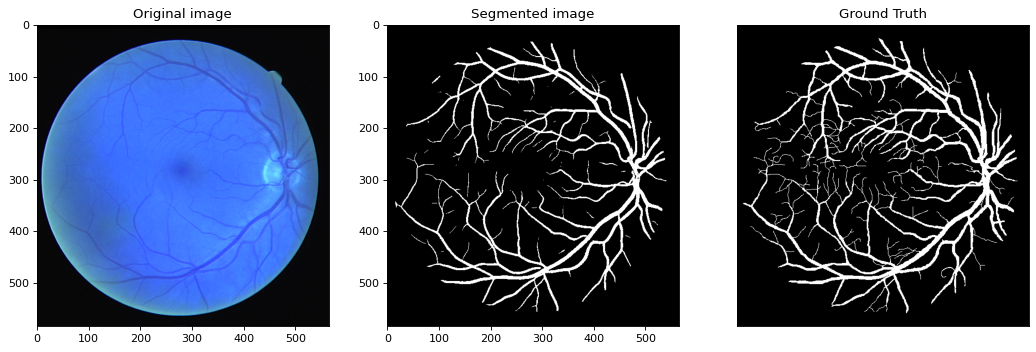

Accuracy:  0.9610740695841921
Precision:  0.9125093438200786
Recall:  0.7344424389861101
F1 Score:  0.8138496768022261
Matthew’s correlation coefficient:  0.7990700511155985


In [ ]:
plt.figure(figsize=(16, 16), dpi=80)

image = cv2.imread('/content/drive/MyDrive/DRIVE/training/images/24_training.tif')
mask=plt.imread("/content/drive/MyDrive/DRIVE/training/mask/24_training_mask.gif")
ground_truth = Image.open('/content/drive/MyDrive/DRIVE/training/1st_manual/24_manual1.gif')
ground_truth = np.array(ground_truth)

out = inference(image, mask)
plt.subplot(1,3,1),plt.imshow(image/255.0)
plt.title("Original image")
plt.subplot(1,3,2),plt.imshow(out, "gray")
plt.title("Segmented image")
plt.subplot(1,3,3),plt.imshow(ground_truth, "gray")
plt.title("Ground Truth")
plt.xticks([]),plt.yticks([])
plt.show()

from PIL import Image 
pred_image = (out*255).astype(np.uint8)

eval(pred_image, ground_truth)

### Inference results on 4 images of the validation set

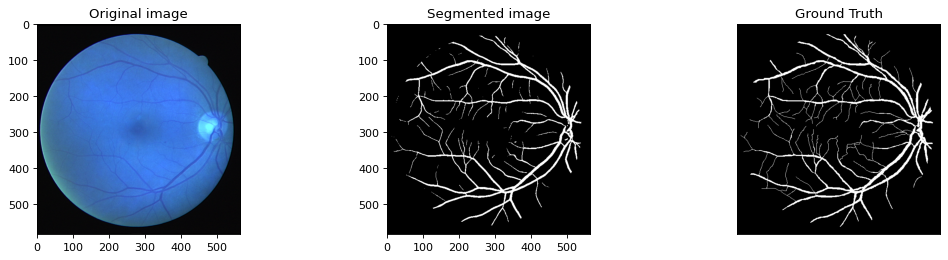

Evaluation result for /content/drive/MyDrive/DRIVE/training/images/32_training.tif
Accuracy:  0.9688386471087405
Precision:  0.8349241998877035
Recall:  0.7714942187963237
F1 Score:  0.8019569320852112
Matthew’s correlation coefficient:  0.7863452510207274




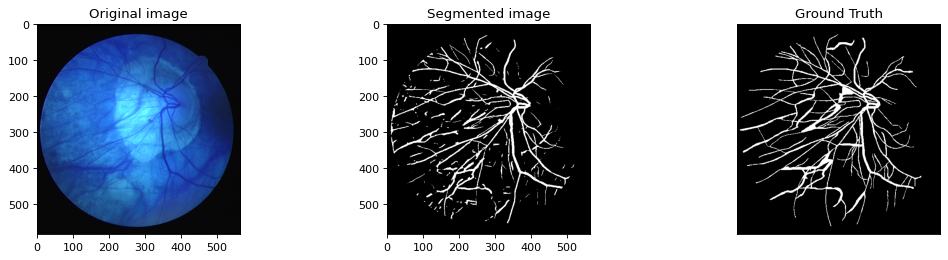

Evaluation result for /content/drive/MyDrive/DRIVE/training/images/34_training.tif
Accuracy:  0.9407746393502243
Precision:  0.7212443148283165
Recall:  0.6434168550809923
F1 Score:  0.6801113111802259
Matthew’s correlation coefficient:  0.6508575708021027




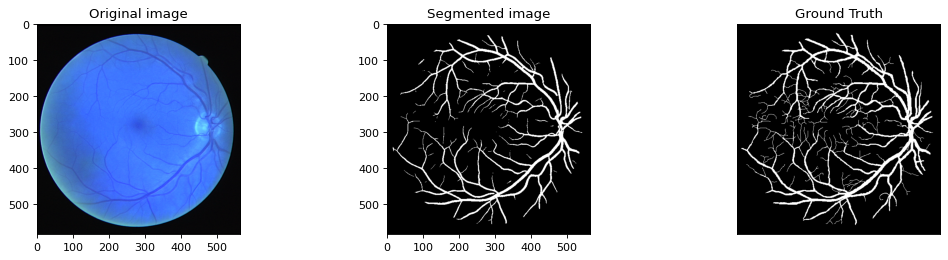

Evaluation result for /content/drive/MyDrive/DRIVE/training/images/24_training.tif
Accuracy:  0.9610740695841921
Precision:  0.9125093438200786
Recall:  0.7344424389861101
F1 Score:  0.8138496768022261
Matthew’s correlation coefficient:  0.7990700511155985




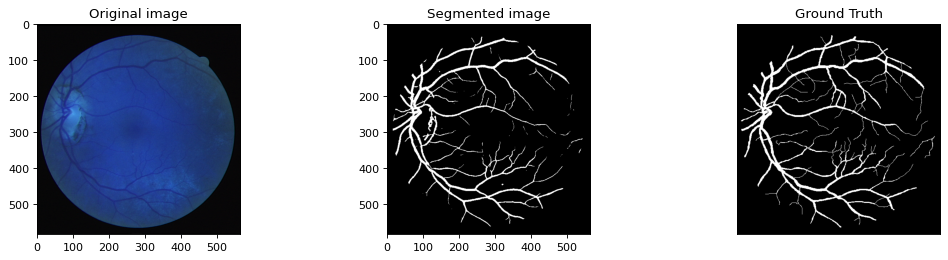

Evaluation result for /content/drive/MyDrive/DRIVE/training/images/26_training.tif
Accuracy:  0.9654533882894897
Precision:  0.8370987911629846
Recall:  0.7283211837667283
F1 Score:  0.7789306285514808
Matthew’s correlation coefficient:  0.7631214473414779




In [ ]:
val_image_path_list=[
    '/content/drive/MyDrive/DRIVE/training/images/32_training.tif', 
    '/content/drive/MyDrive/DRIVE/training/images/34_training.tif', 
    '/content/drive/MyDrive/DRIVE/training/images/24_training.tif', 
    '/content/drive/MyDrive/DRIVE/training/images/26_training.tif', 
]

val_image_mask_list = [
    "/content/drive/MyDrive/DRIVE/training/mask/32_training_mask.gif",
    "/content/drive/MyDrive/DRIVE/training/mask/34_training_mask.gif",
    "/content/drive/MyDrive/DRIVE/training/mask/24_training_mask.gif",
    "/content/drive/MyDrive/DRIVE/training/mask/26_training_mask.gif"
]

val_image_groundtruth_list = [
    '/content/drive/MyDrive/DRIVE/training/1st_manual/32_manual1.gif',
    '/content/drive/MyDrive/DRIVE/training/1st_manual/34_manual1.gif',
    '/content/drive/MyDrive/DRIVE/training/1st_manual/24_manual1.gif',
    '/content/drive/MyDrive/DRIVE/training/1st_manual/26_manual1.gif'
]

save_name = [
    "32_inf_unet.gif",
    "34_inf_unet.gif",
    "24_inf_unet.gif",
    "26_inf_unet.gif"
]

for i in range(4):
  plt.figure(figsize=(16, 16), dpi=80)
  image = cv2.imread(val_image_path_list[i])
  mask=plt.imread(val_image_mask_list[i])
  ground_truth = Image.open(val_image_groundtruth_list[i])
  ground_truth = np.array(ground_truth)

  out = inference(image, mask)
  plt.subplot(4,3,3*i+1),plt.imshow(image/255.0)
  plt.title("Original image") 
  plt.subplot(4,3,3*i+2),plt.imshow(out, "gray")
  plt.title("Segmented image")
  plt.subplot(4,3,3*i+3),plt.imshow(ground_truth, "gray")
  plt.title("Ground Truth")
  plt.xticks([]),plt.yticks([])
  plt.show()

  from PIL import Image 
  pred_image = (out*255).astype(np.uint8)
  print("Evaluation result for "+val_image_path_list[i])
  eval(pred_image, ground_truth)
  print("\n")

  out = (out*255).astype(np.uint8)
  im_pil = Image.fromarray(out)
  im_pil.save(save_name[i])

### Inference on the assigned image 25_test.tif

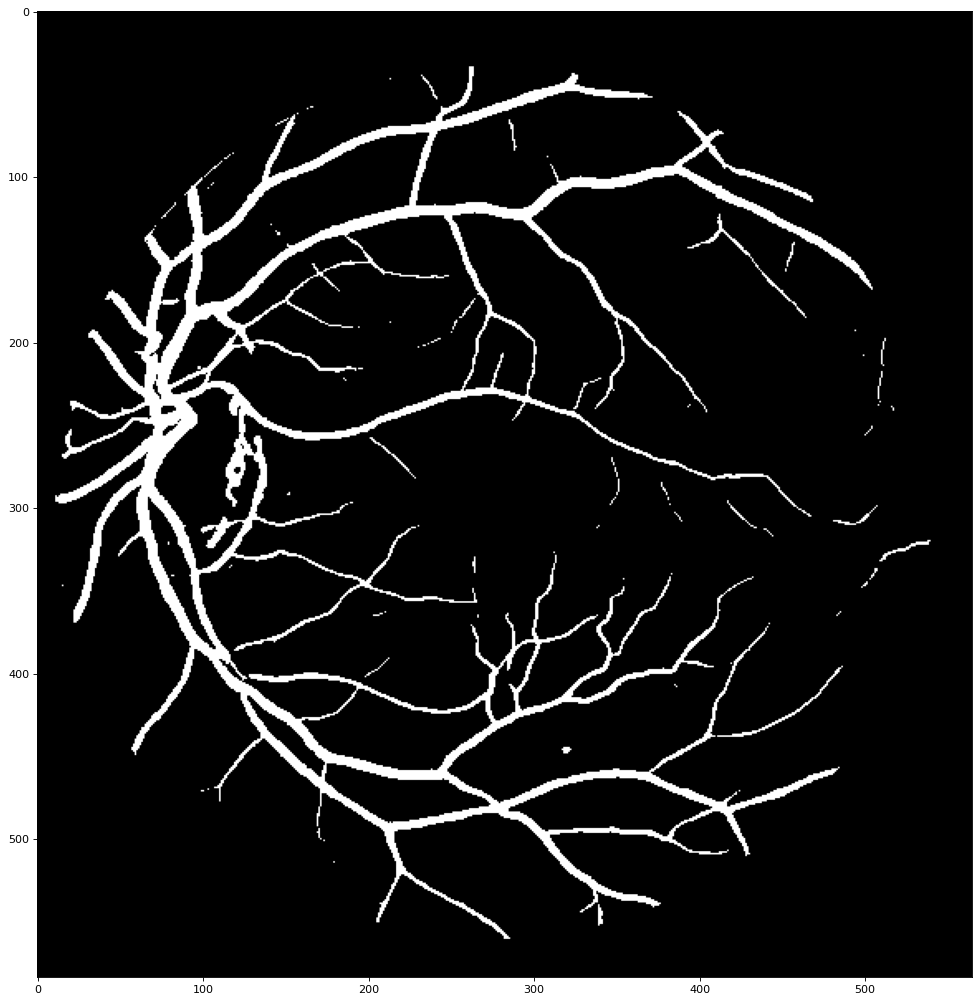

In [ ]:
plt.figure(figsize=(16, 16), dpi=80)

image = cv2.imread('/content/drive/MyDrive/DRIVE/25_test(1).tif')
mask=plt.imread("/content/drive/MyDrive/DRIVE/training/mask/24_training_mask.gif")

out_submission = inference(image, mask)
plt.imshow(out_submission, "gray")
out_submission = (out_submission*255).astype(np.uint8)
im_pil = Image.fromarray(out_submission)
im_pil.save("img_submission.gif")